# Customer Clustering Analysis with Selected Features


In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../')

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

# Set root variables for paths
RESULTS_ROOT = Path('../../results/eda')
DATA_ROOT = Path('../../data')

# Create results directory structure if it doesn't exist
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
print(f"✅ Results directory ready: {RESULTS_ROOT.absolute()}")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")

✅ Results directory ready: c:\Users\tom\coding_projects\data_analytics_projects\h_and_m_data_analysis\notebooks\clustering\..\..\results\eda
Libraries imported successfully


## 1. Data Loading and Feature Selection


In [2]:
# Load the customer features dataset
features_df = pl.read_parquet(DATA_ROOT / 'features/final/customers_features_final.parquet')
print(f"Loaded customer features from: {DATA_ROOT / 'features/final/customers_features_final.parquet'}")

print(f"Dataset shape: {features_df.shape}")
print(f"Columns: {features_df.columns}")

Loaded customer features from: ..\..\data\features\final\customers_features_final.parquet
Dataset shape: (525075, 16)
Columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score', 'dataset_created_at', 'created_by']


In [3]:
# Define the selected features for clustering
selected_features = [
    'FN', 'Active', 'age', 'recency', 'frequency', 'monetary',
    'purchase_diversity_score', 'price_sensitivity_index', 
    'colour_preference_entropy', 'style_consistency_score'
]

print(f"Selected features: {selected_features}")

# Check which features are available
available_features = [col for col in selected_features if col in features_df.columns]
missing_features = [col for col in selected_features if col not in features_df.columns]

print(f"Available features: {available_features}")
if missing_features:
    print(f"Missing features: {missing_features}")

Selected features: ['FN', 'Active', 'age', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score']
Available features: ['FN', 'Active', 'age', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score']


In [4]:
# Extract clustering data with selected features
clustering_data = features_df.select(available_features).drop_nulls()

print(f"Clustering data shape: {clustering_data.shape}")
print(f"Features summary:")
print(clustering_data.describe())

Clustering data shape: (525075, 10)
Features summary:
shape: (9, 11)
┌────────────┬──────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ FN       ┆ Active   ┆ age       ┆ … ┆ purchase_ ┆ price_sen ┆ colour_pr ┆ style_con │
│ ---        ┆ ---      ┆ ---      ┆ ---       ┆   ┆ diversity ┆ sitivity_ ┆ eference_ ┆ sistency_ │
│ str        ┆ f64      ┆ f64      ┆ f64       ┆   ┆ _score    ┆ index     ┆ entropy   ┆ score     │
│            ┆          ┆          ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆          ┆          ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 525075.0 ┆ 525075.0 ┆ 525075.0  ┆ … ┆ 525075.0  ┆ 525075.0  ┆ 525075.0  ┆ 525075.0  │
│ null_count ┆ 0.0      ┆ 0.0      ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 0.42024

In [5]:
# Convert to pandas and prepare for sklearn
clustering_pandas = clustering_data.to_pandas()
X = clustering_pandas.values

print(f"Feature matrix shape: {X.shape}")
print(f"Sample statistics:")
print(f"Mean: {X.mean(axis=0)}")
print(f"Std: {X.std(axis=0)}")

Feature matrix shape: (525075, 10)
Sample statistics:
Mean: [  0.42024092   0.41334857  35.01871733  38.5420997    7.43587297
 199.56823261   0.95552387   0.46513554   1.44489261   0.33112055]
Std: [  0.4935975    0.49243429  13.86287187  26.83282539   9.05913529
 300.54444209   0.74889329   0.36434049   0.98482135   0.40975494]


## 2. Data Preprocessing and Scaling


In [6]:
# Standardise features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Scaled data statistics:")
print(f"Mean: {X_scaled.mean(axis=0).round(3)}")
print(f"Std: {X_scaled.std(axis=0).round(3)}")

Scaled data shape: (525075, 10)
Scaled data statistics:
Mean: [ 0. -0. -0. -0.  0.  0.  0.  0.  0.  0.]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 4. K-Means Clustering with K=5


Using optimal K = 5
Final clustering with K=5
Cluster sizes:
  Cluster 0: 199,284 customers (38.0%)
  Cluster 1: 89,012 customers (17.0%)
  Cluster 2: 54,837 customers (10.4%)
  Cluster 3: 147,826 customers (28.2%)
  Cluster 4: 34,116 customers (6.5%)


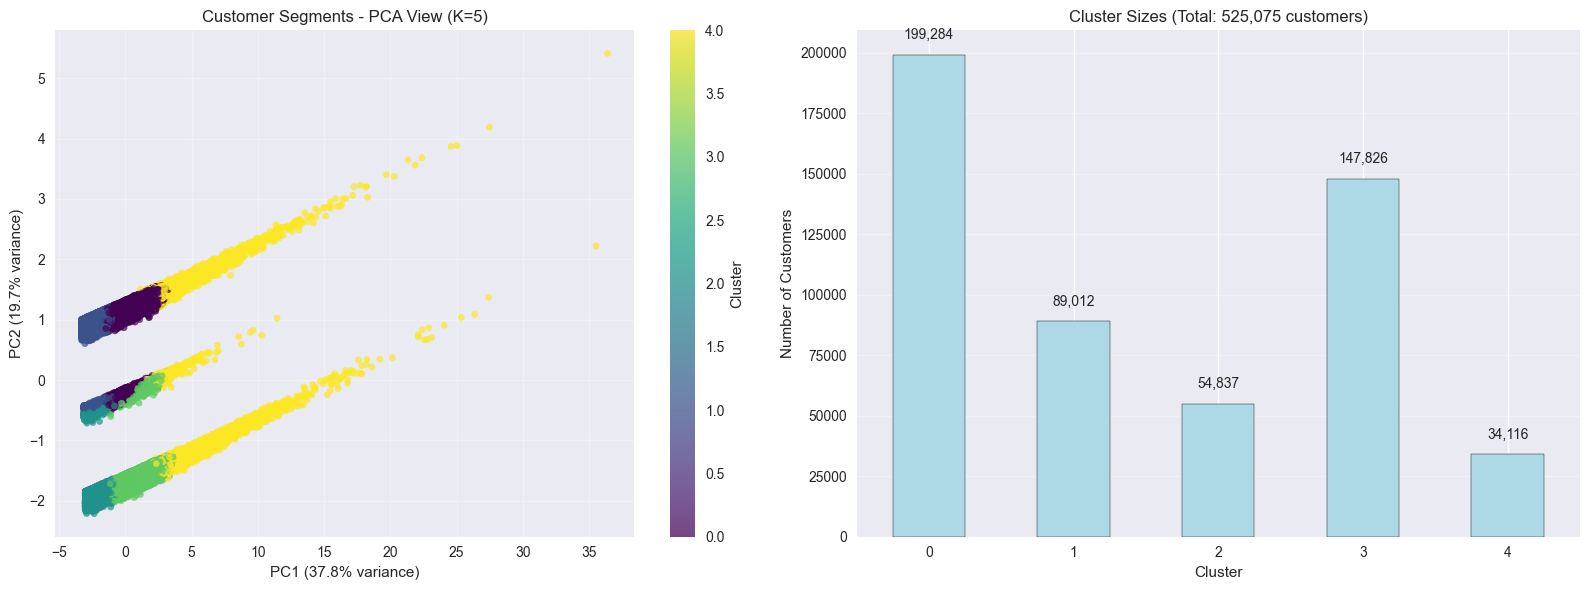

\nPCA Analysis:
First 2 components explain 57.5% of variance
Individual component variance: PC1=37.8%, PC2=19.7%


In [7]:
# Find optimal K using elbow method and metrics
optimal_k = 5  # Based on elbow analysis and business context

print(f"Using optimal K = {optimal_k}")

# Train final model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to data
clustering_pandas = clustering_data.to_pandas()
clustering_pandas['cluster'] = cluster_labels

print(f"Final clustering with K={optimal_k}")
print(f"Cluster sizes:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count:,} customers ({count/len(cluster_labels)*100:.1f}%)")

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot clustering results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=20)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title(f'Customer Segments - PCA View (K={optimal_k})')
ax1.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Cluster')

# Cluster sizes bar plot
cluster_counts.plot(kind='bar', ax=ax2, color='lightblue', edgecolor='black')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Customers')
ax2.set_title(f'Cluster Sizes (Total: {len(cluster_labels):,} customers)')
ax2.tick_params(axis='x', rotation=0)
ax2.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, count in enumerate(cluster_counts):
    ax2.text(i, count + len(cluster_labels)*0.01, f'{count:,}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'customer_clustering_pca_visualisation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\\nPCA Analysis:")
print(f"First 2 components explain {pca.explained_variance_ratio_.sum():.1%} of variance")
print(f"Individual component variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")

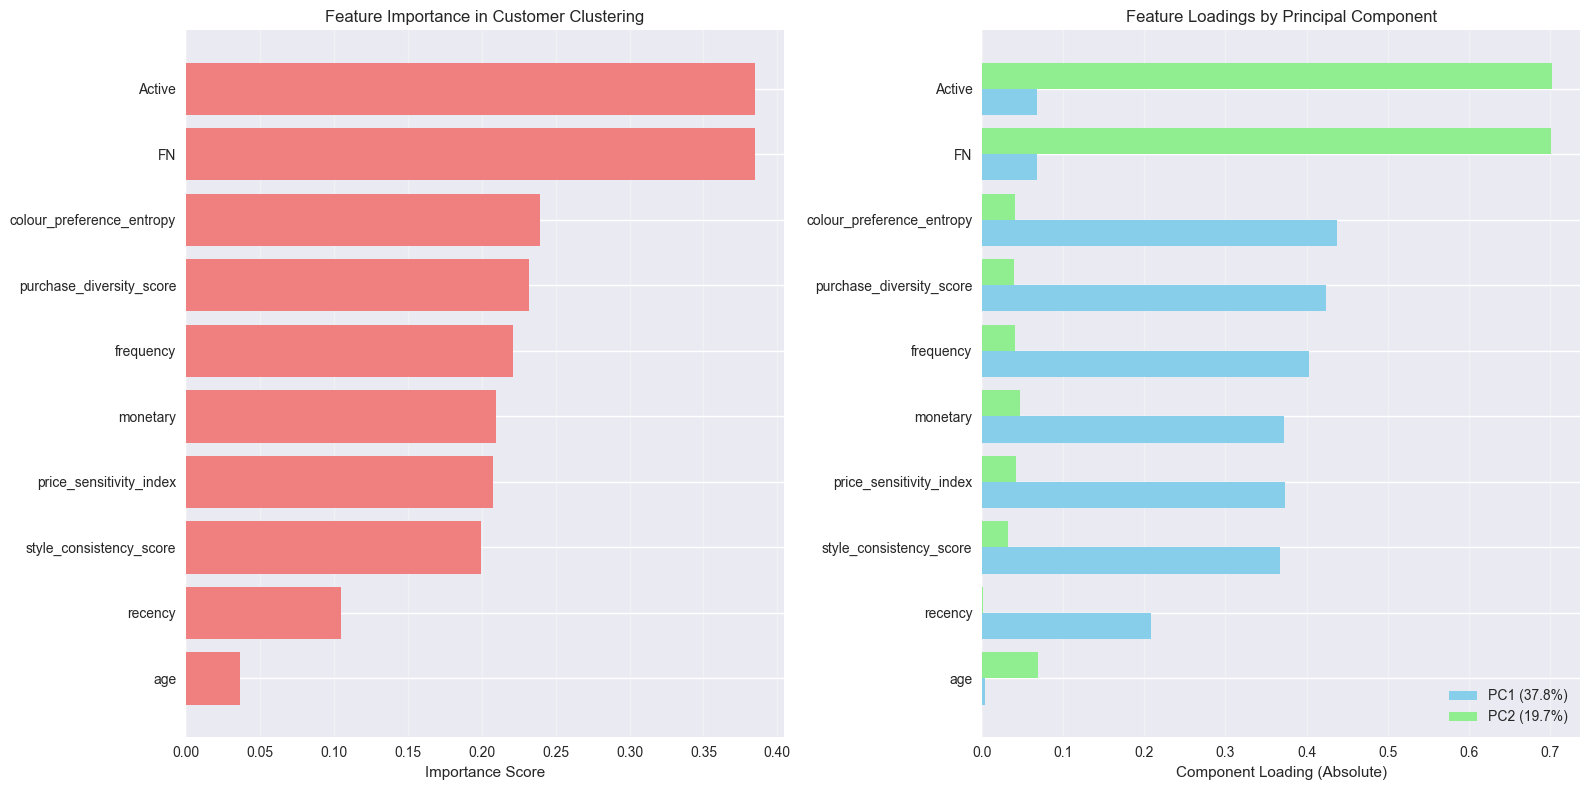


Top 5 Most Important Features:
1. frequency: 0.221
2. purchase_diversity_score: 0.232
3. colour_preference_entropy: 0.239
4. FN: 0.385
5. Active: 0.385

Feature Analysis:
• Active is the most discriminative feature
• PC1 is most influenced by: colour_preference_entropy
• PC2 is most influenced by: Active


In [8]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'pc1_loading': np.abs(pca.components_[0]),
    'pc2_loading': np.abs(pca.components_[1])
})

# Calculate overall importance as mean of loadings
feature_importance['importance'] = (feature_importance['pc1_loading'] + feature_importance['pc2_loading']) / 2
feature_importance = feature_importance.sort_values('importance', ascending=True)

# Create feature importance plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Overall importance
ax1.barh(feature_importance['feature'], feature_importance['importance'], color='lightcoral')
ax1.set_xlabel('Importance Score')
ax1.set_title('Feature Importance in Customer Clustering')
ax1.grid(True, alpha=0.3, axis='x')

# Component loadings
y_pos = np.arange(len(feature_importance))
ax2.barh(y_pos - 0.2, feature_importance['pc1_loading'], 0.4, 
         label=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', color='skyblue')
ax2.barh(y_pos + 0.2, feature_importance['pc2_loading'], 0.4,
         label=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', color='lightgreen')

ax2.set_yticks(y_pos)
ax2.set_yticklabels(feature_importance['feature'])
ax2.set_xlabel('Component Loading (Absolute)')
ax2.set_title('Feature Loadings by Principal Component')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'customer_clustering_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.tail().iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.3f}")
    
print("\nFeature Analysis:")
print(f"• {feature_importance.iloc[-1]['feature']} is the most discriminative feature")
print(f"• PC1 is most influenced by: {feature_importance.loc[feature_importance['pc1_loading'].idxmax(), 'feature']}")
print(f"• PC2 is most influenced by: {feature_importance.loc[feature_importance['pc2_loading'].idxmax(), 'feature']}")

Using full dataset of 525,075 customers for visualisation


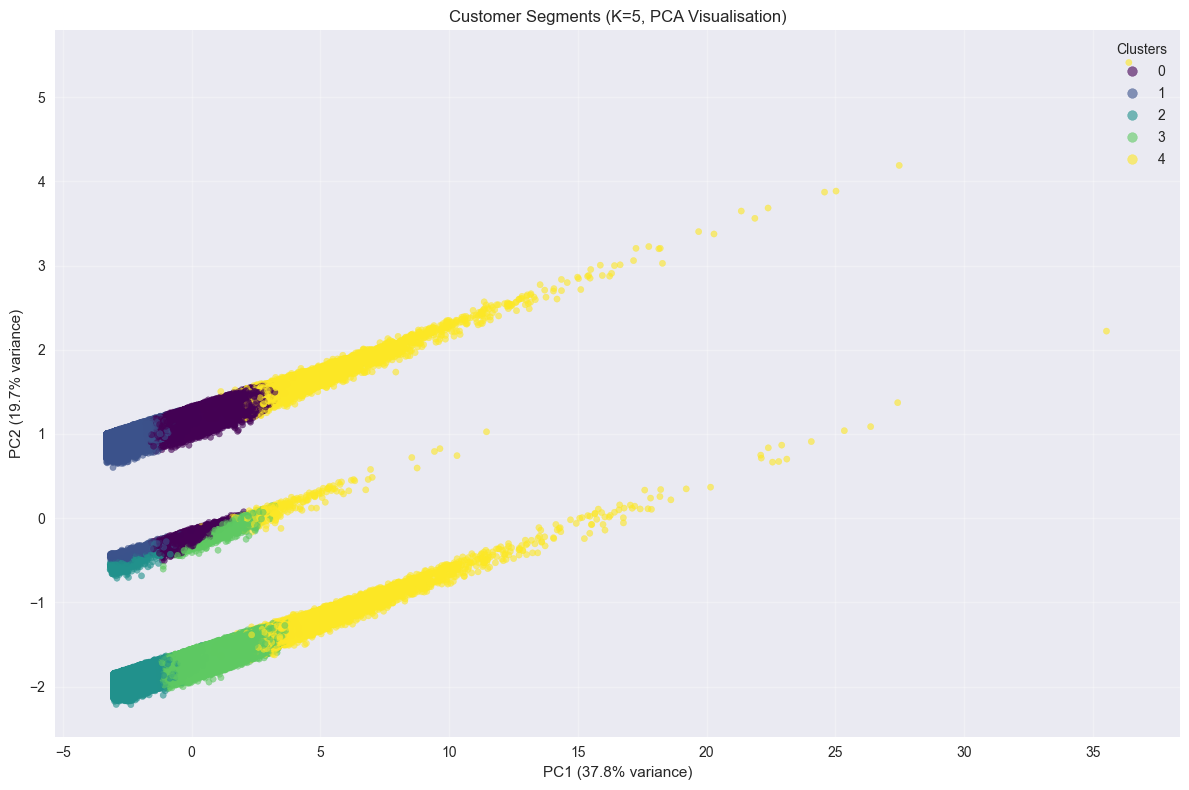


Cluster Centres (Original Feature Space):
              FN  Active    age  recency  frequency  monetary  \
Cluster 0 -0.836  -0.839 -0.053   -0.030     -0.045    -0.078   
Cluster 1 -0.836  -0.839 -0.023    0.349     -0.577    -0.468   
Cluster 2  1.175   1.182  0.100    0.370     -0.589    -0.480   
Cluster 3  1.175   1.179  0.040   -0.120      0.008    -0.055   
Cluster 4  0.087   0.086  0.032   -0.805      2.671     2.681   

           purchase_diversity_score  price_sensitivity_index  \
Cluster 0                     0.341                    0.280   
Cluster 1                    -1.175                   -0.967   
Cluster 2                    -1.179                   -0.970   
Cluster 3                     0.409                    0.319   
Cluster 4                     1.196                    1.058   

           colour_preference_entropy  style_consistency_score  
Cluster 0                      0.271                   -0.592  
Cluster 1                     -1.073                 

In [9]:
# Use full dataset for visualisation
print(f"Using full dataset of {len(X_pca):,} customers for visualisation")

# Create PCA visualisation with labelled clusters instead of a scale
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=cluster_labels, cmap='viridis', 
                     alpha=0.6, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'Customer Segments (K={optimal_k}, PCA Visualisation)')
plt.legend(*scatter.legend_elements(), title="Clusters", loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'customer_clustering_pca_visualisation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print cluster centres in original feature space
print(f"\nCluster Centres (Original Feature Space):")
print("=" * 50)
cluster_centres = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=selected_features,
    index=[f'Cluster {i}' for i in range(optimal_k)]
)
print(cluster_centres.round(3))

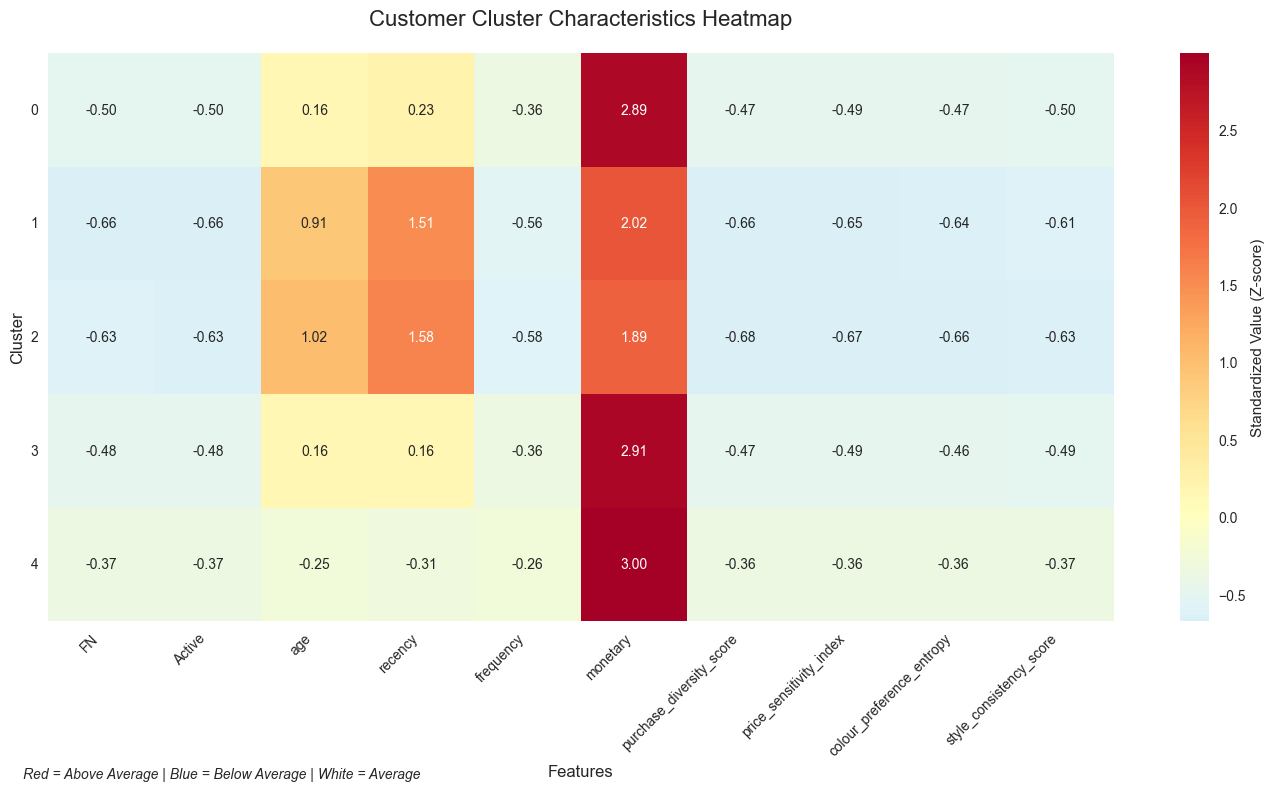

\nCluster Characteristics Summary:
\nRaw Averages by Cluster:
           FN  Active    age  recency  frequency  monetary  \
cluster                                                      
0        0.01    0.00  34.28    37.73       7.04    176.16   
1        0.01    0.00  34.70    47.90       2.21     59.05   
2        1.00    1.00  36.41    48.46       2.10     55.25   
3        1.00    0.99  35.58    35.32       7.51    183.09   
4        0.46    0.46  35.46    16.93      31.66   1006.31   

         purchase_diversity_score  price_sensitivity_index  \
cluster                                                      
0                            1.21                     0.57   
1                            0.08                     0.11   
2                            0.07                     0.11   
3                            1.26                     0.58   
4                            1.85                     0.85   

         colour_preference_entropy  style_consistency_score  
cluste

In [10]:
# Create cluster characteristics heatmap
cluster_profiles = clustering_pandas.groupby('cluster')[selected_features].mean()

# Standardize the values for better visualization
from sklearn.preprocessing import StandardScaler
scaler_viz = StandardScaler()
cluster_profiles_scaled = pd.DataFrame(
    scaler_viz.fit_transform(cluster_profiles.T).T,
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# Create heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profiles_scaled, 
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardized Value (Z-score)'})

plt.title('Customer Cluster Characteristics Heatmap', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add interpretation guide
plt.figtext(0.02, 0.02, 'Red = Above Average | Blue = Below Average | White = Average', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'customer_clustering_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\\nCluster Characteristics Summary:")
print("=" * 50)
print("\\nRaw Averages by Cluster:")
print(cluster_profiles.round(2))

print("\\nStandardised Values (Z-scores):")
print(cluster_profiles_scaled.round(2))

print("\\nInterpretation Guide:")
print("• Positive values (red): Above average for that feature")
print("• Negative values (blue): Below average for that feature") 
print("• Values near 0 (white): Close to average for that feature")
print("• |Z-score| > 1: Significantly different from average")
print("• |Z-score| > 2: Very significantly different from average")

<Figure size 1200x800 with 0 Axes>

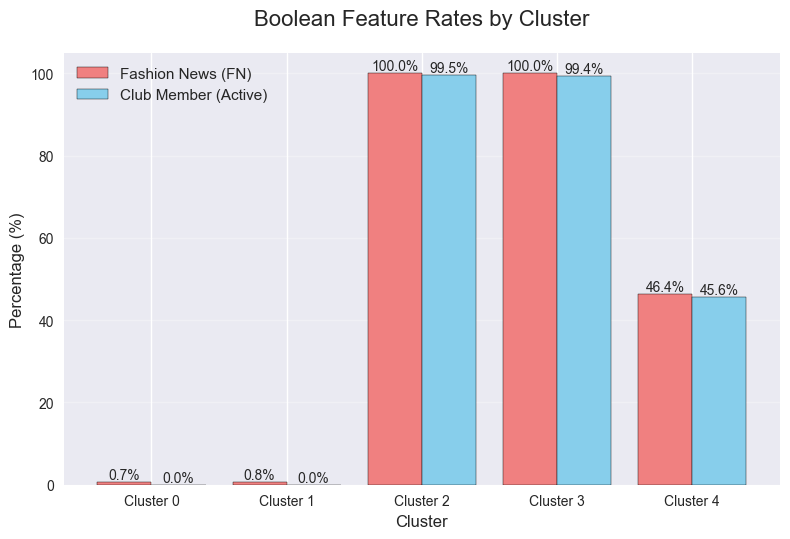

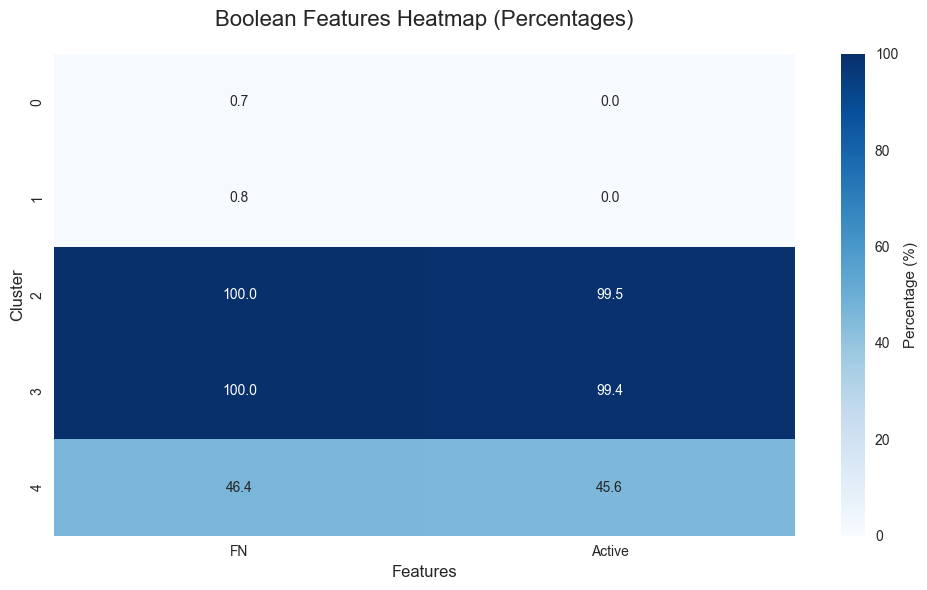

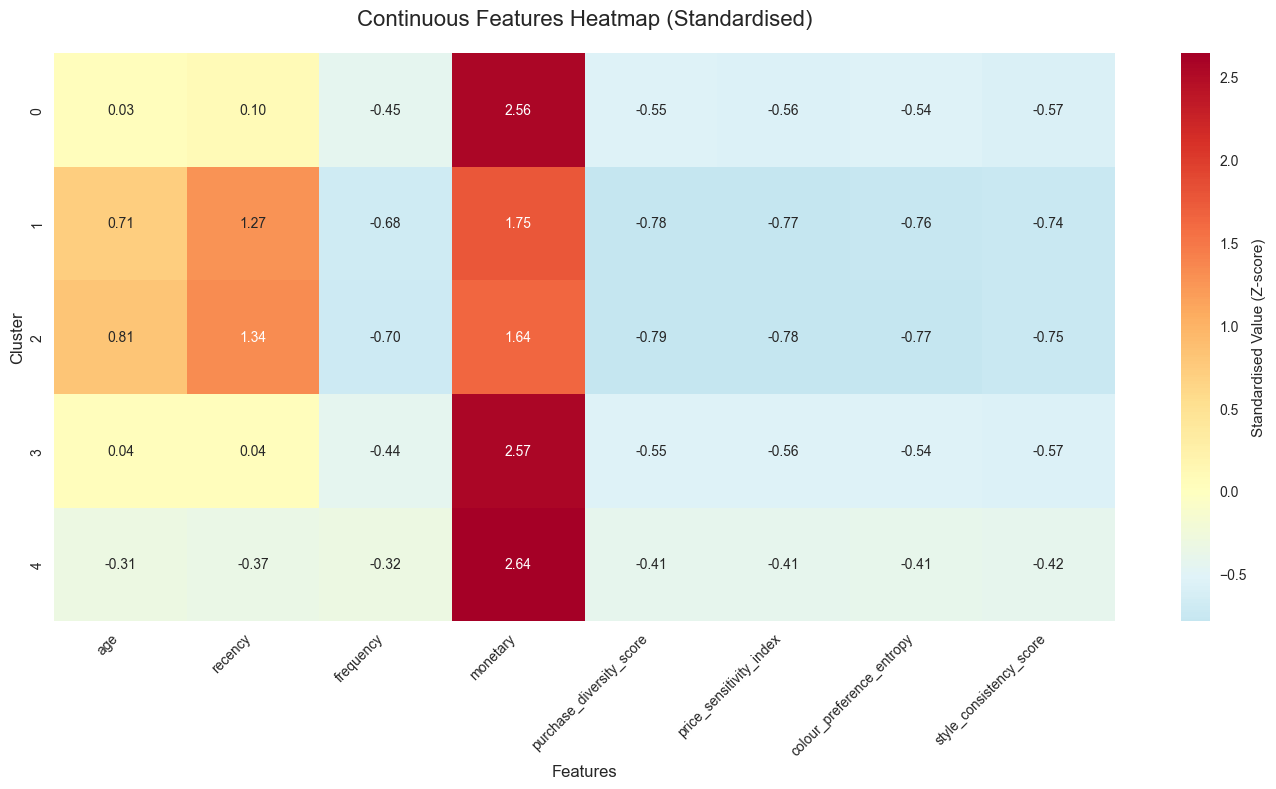

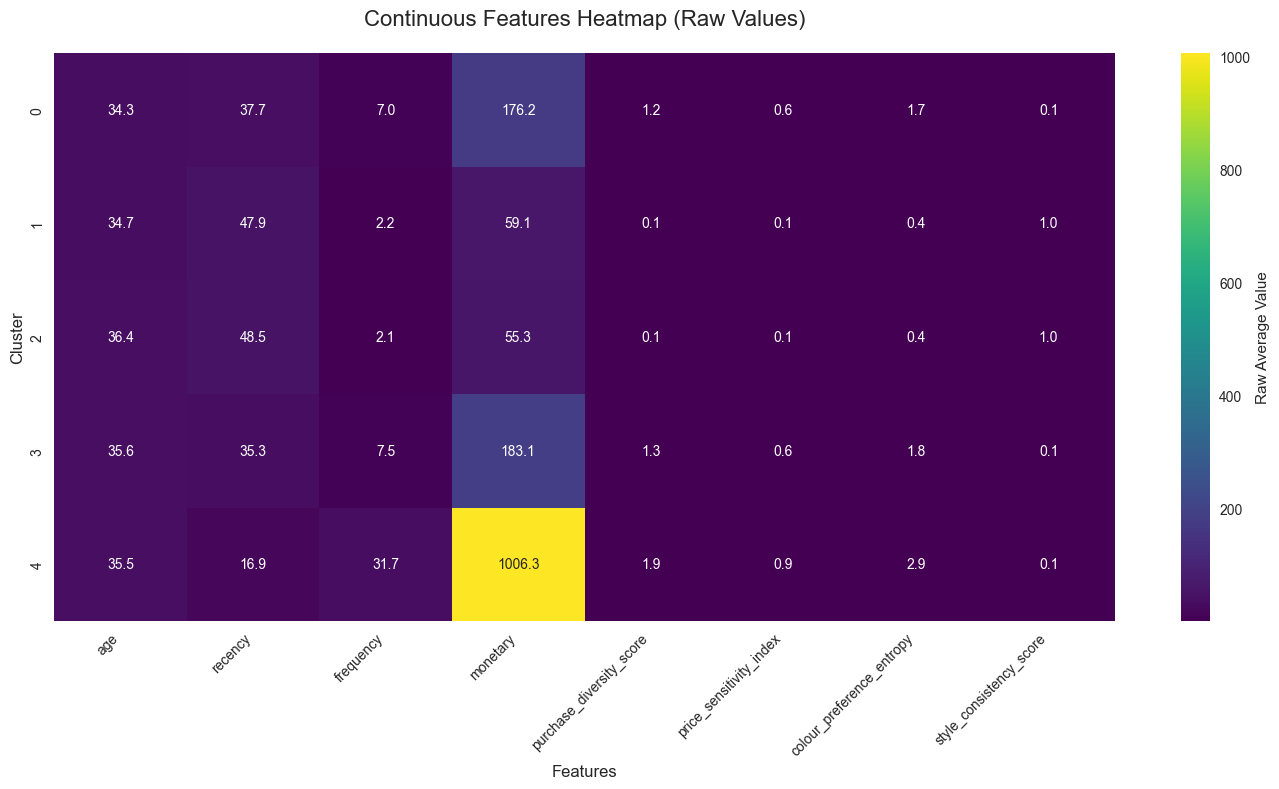

Enhanced Cluster Analysis

🔢 BOOLEAN FEATURES (Rates/Percentages):
            FN  Active
cluster               
0          0.7     0.0
1          0.8     0.0
2        100.0    99.5
3        100.0    99.4
4         46.4    45.6

📊 CONTINUOUS FEATURES (Raw Averages):
           age  recency  frequency  monetary  purchase_diversity_score  \
cluster                                                                  
0        34.28    37.73       7.04    176.16                      1.21   
1        34.70    47.90       2.21     59.05                      0.08   
2        36.41    48.46       2.10     55.25                      0.07   
3        35.58    35.32       7.51    183.09                      1.26   
4        35.46    16.93      31.66   1006.31                      1.85   

         price_sensitivity_index  colour_preference_entropy  \
cluster                                                       
0                           0.57                       1.71   
1                        

In [11]:
# Create separate visualisations for boolean and continuous features
boolean_features = ['FN', 'Active']
continuous_features = [col for col in selected_features if col not in boolean_features]

# Calculate cluster profiles
cluster_profiles = clustering_pandas.groupby('cluster')[selected_features].mean()

# Separate boolean and continuous features
boolean_profiles = cluster_profiles[boolean_features] * 100  # Convert to percentages
continuous_profiles = cluster_profiles[continuous_features]

# Standardise continuous features for better comparison
from sklearn.preprocessing import StandardScaler
scaler_continuous = StandardScaler()
continuous_profiles_scaled = pd.DataFrame(
    scaler_continuous.fit_transform(continuous_profiles.T).T,
    columns=continuous_profiles.columns,
    index=continuous_profiles.index
)

# 1. Boolean features as percentage bars
plt.figure(figsize=(12, 8))
ax = boolean_profiles.plot(kind='bar', color=['lightcoral', 'skyblue'], 
                          edgecolor='black', width=0.8)
plt.title('Boolean Feature Rates by Cluster', fontsize=16, pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(range(optimal_k), [f'Cluster {i}' for i in range(optimal_k)], rotation=0)
plt.legend(['Fashion News (FN)', 'Club Member (Active)'], loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'boolean_features_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Boolean features heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(boolean_profiles, annot=True, fmt='.1f', cmap='Blues', 
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Boolean Features Heatmap (Percentages)', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'boolean_features_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Continuous features heatmap (standardised)
plt.figure(figsize=(14, 8))
sns.heatmap(continuous_profiles_scaled, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, cbar_kws={'label': 'Standardised Value (Z-score)'})
plt.title('Continuous Features Heatmap (Standardised)', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'continuous_features_heatmap_standardised.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Raw continuous values for reference
plt.figure(figsize=(14, 8))
sns.heatmap(continuous_profiles, annot=True, fmt='.1f', cmap='viridis', 
            cbar_kws={'label': 'Raw Average Value'})
plt.title('Continuous Features Heatmap (Raw Values)', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'continuous_features_heatmap_raw.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced Cluster Analysis")
print("=" * 50)
print("\n🔢 BOOLEAN FEATURES (Rates/Percentages):")
print(boolean_profiles.round(1))

print("\n📊 CONTINUOUS FEATURES (Raw Averages):")
print(continuous_profiles.round(2))

print("\n📈 CONTINUOUS FEATURES (Standardised Z-scores):")
print(continuous_profiles_scaled.round(2))

print("\n💡 INTERPRETATION GUIDE:")
print("Boolean Features:")
print("• Values show percentage of customers in each cluster with that characteristic")
print("• Higher % = more customers in that cluster have this trait")
print()
print("Continuous Features (Z-scores):")
print("• Positive values (red): Above average for that feature")
print("• Negative values (blue): Below average for that feature")
print("• |Z-score| > 1: Significantly different from average")
print("• |Z-score| > 2: Very significantly different from average")

Age Analysis by Customer Cluster

Age Statistics by Cluster:
          Count   Mean  Median  Std Dev   Min   Max   Q25   Q75
cluster                                                        
0        199284  34.28    29.0    13.09  16.0  99.0  24.0  46.0
1         89012  34.70    29.0    14.22  16.0  98.0  23.0  47.0
2         54837  36.41    31.0    15.49  16.0  99.0  23.0  50.0
3        147826  35.58    30.0    14.32  16.0  99.0  23.0  48.0
4         34116  35.46    31.0    12.17  17.0  91.0  26.0  46.0


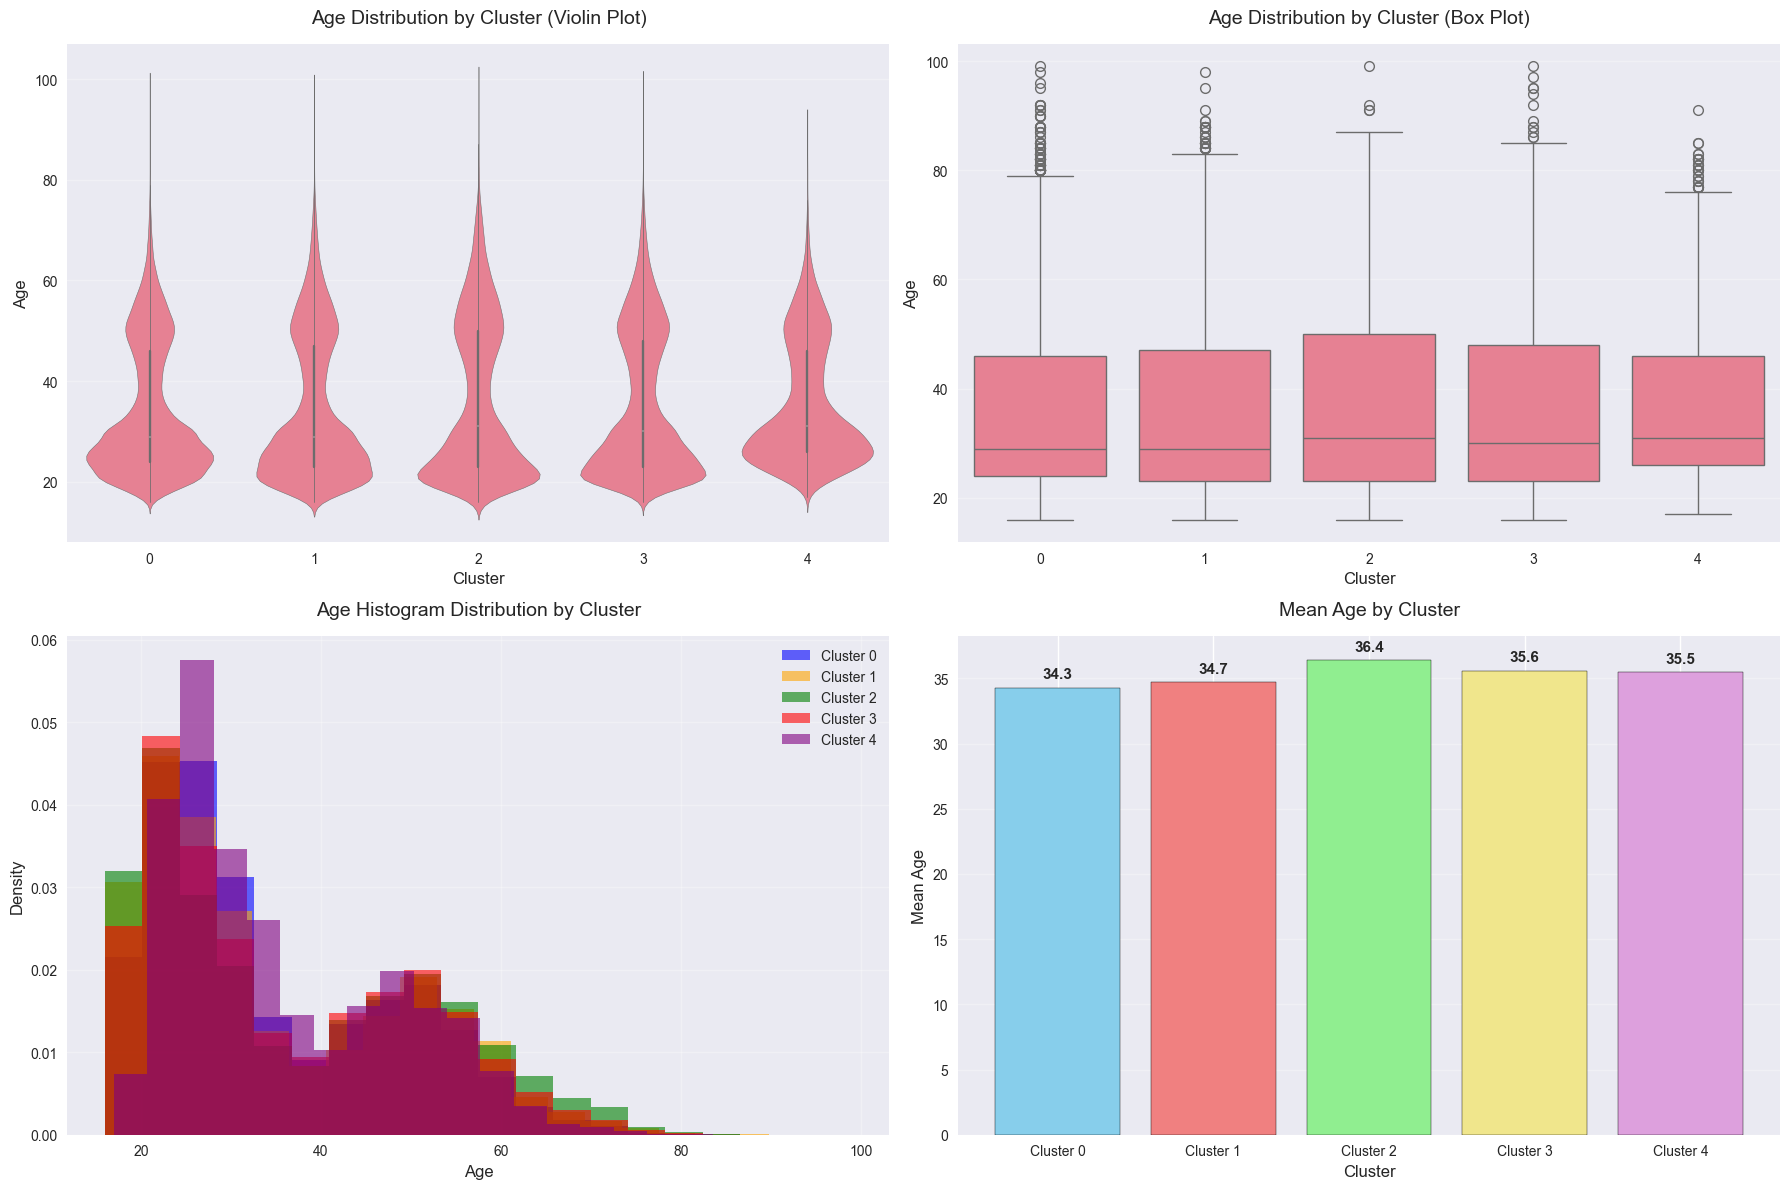


Age Group Distribution by Cluster (%):
age_group  Mature (45-54)  Middle-aged (35-44)  Senior (55+)  Young (16-24)  \
cluster                                                                       
0                    17.1                 10.5           9.4           27.7   
1                    17.1                  9.8          11.8           31.4   
2                    18.2                  9.9          16.2           32.7   
3                    18.7                 10.8          12.7           30.6   
4                    17.6                 13.9           8.9           17.8   

age_group  Young Adult (25-34)  
cluster                         
0                         35.3  
1                         29.9  
2                         23.0  
3                         27.2  
4                         41.8  


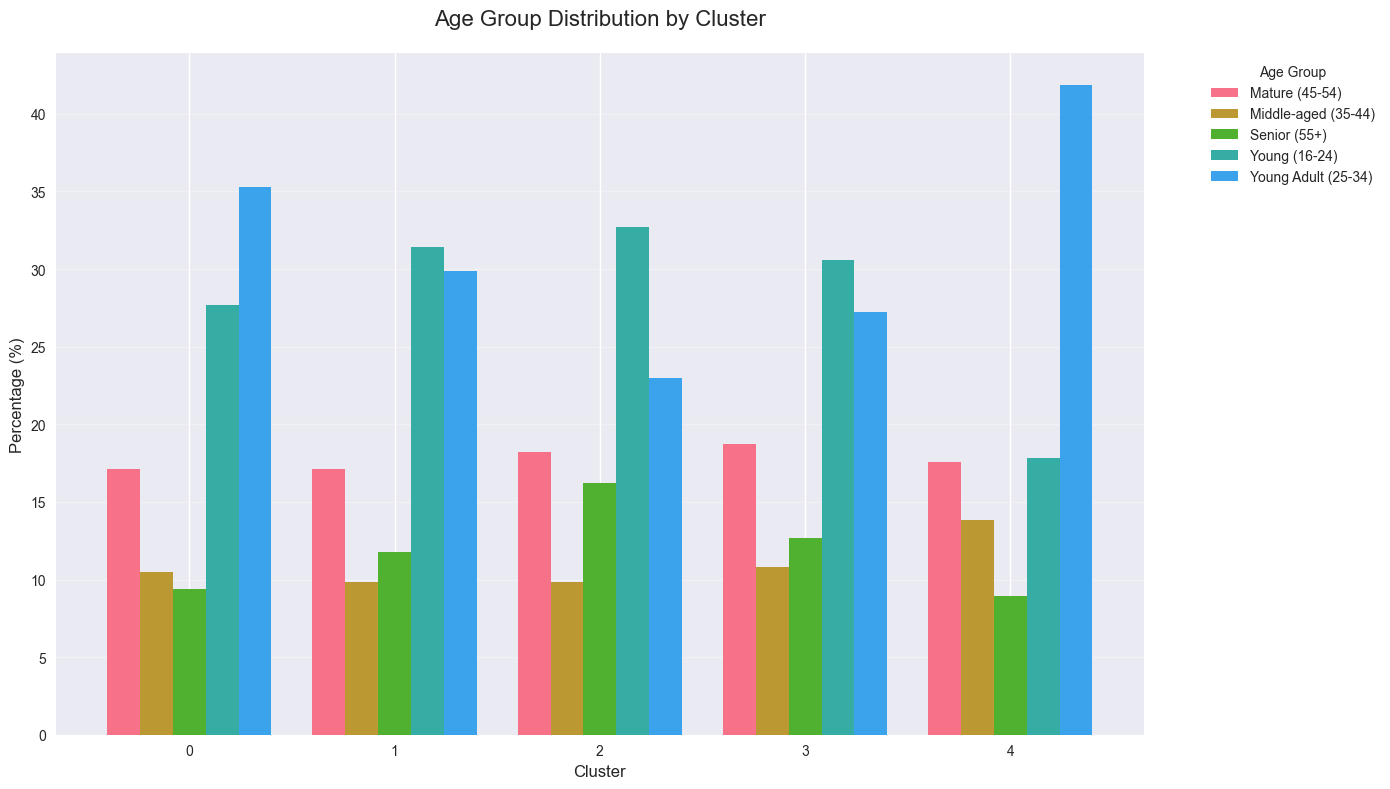


🎯 KEY AGE INSIGHTS BY CLUSTER:

Cluster 0 (199,284 customers):
  • Mean age: 34.3 years
  • Dominant age group: Young Adult (25-34) (35.3%)
  • Age range: 16 - 99 years

Cluster 1 (89,012 customers):
  • Mean age: 34.7 years
  • Dominant age group: Young (16-24) (31.4%)
  • Age range: 16 - 98 years

Cluster 2 (54,837 customers):
  • Mean age: 36.4 years
  • Dominant age group: Young (16-24) (32.7%)
  • Age range: 16 - 99 years

Cluster 3 (147,826 customers):
  • Mean age: 35.6 years
  • Dominant age group: Young (16-24) (30.6%)
  • Age range: 16 - 99 years

Cluster 4 (34,116 customers):
  • Mean age: 35.5 years
  • Dominant age group: Young Adult (25-34) (41.8%)
  • Age range: 17 - 91 years

💡 BUSINESS IMPLICATIONS:
• Age differences suggest different life stages and purchasing behaviours
• Younger clusters may prefer digital engagement and trendy products
• Older clusters may value quality, comfort, and traditional shopping
• Age-targeted marketing campaigns can improve conversion ra

In [12]:
# Age Analysis by Cluster
print("Age Analysis by Customer Cluster")
print("=" * 50)

# Calculate age statistics by cluster
age_stats = clustering_pandas.groupby('cluster')['age'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.25),  # 25th percentile
    lambda x: x.quantile(0.75)   # 75th percentile
]).round(2)
age_stats.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Q25', 'Q75']

print("\nAge Statistics by Cluster:")
print(age_stats)

# Create comprehensive age visualisations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Age distribution by cluster (violin plot)
import seaborn as sns
sns.violinplot(data=clustering_pandas, x='cluster', y='age', ax=ax1)
ax1.set_title('Age Distribution by Cluster (Violin Plot)', fontsize=14, pad=15)
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Age', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Age distribution by cluster (box plot)
sns.boxplot(data=clustering_pandas, x='cluster', y='age', ax=ax2)
ax2.set_title('Age Distribution by Cluster (Box Plot)', fontsize=14, pad=15)
ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('Age', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Age histograms by cluster
colors = ['blue', 'orange', 'green', 'red', 'purple']
for i in range(optimal_k):
    cluster_ages = clustering_pandas[clustering_pandas['cluster'] == i]['age']
    ax3.hist(cluster_ages, bins=20, alpha=0.6, label=f'Cluster {i}', 
             color=colors[i % len(colors)], density=True)

ax3.set_title('Age Histogram Distribution by Cluster', fontsize=14, pad=15)
ax3.set_xlabel('Age', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Mean age by cluster (bar chart)
mean_ages = clustering_pandas.groupby('cluster')['age'].mean()
bars = ax4.bar(range(optimal_k), mean_ages, 
               color=['skyblue', 'lightcoral', 'lightgreen', 'khaki', 'plum'][:optimal_k],
               edgecolor='black')
ax4.set_title('Mean Age by Cluster', fontsize=14, pad=15)
ax4.set_xlabel('Cluster', fontsize=12)
ax4.set_ylabel('Mean Age', fontsize=12)
ax4.set_xticks(range(optimal_k))
ax4.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, age in zip(bars, mean_ages):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{age:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'age_analysis_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

# Age group analysis
def categorise_age(age):
    if age < 25:
        return 'Young (16-24)'
    elif age < 35:
        return 'Young Adult (25-34)'
    elif age < 45:
        return 'Middle-aged (35-44)'
    elif age < 55:
        return 'Mature (45-54)'
    else:
        return 'Senior (55+)'

clustering_pandas['age_group'] = clustering_pandas['age'].apply(categorise_age)

# Age group distribution by cluster
age_group_dist = pd.crosstab(clustering_pandas['cluster'], clustering_pandas['age_group'], 
                           normalize='index') * 100

print(f"\nAge Group Distribution by Cluster (%):")
print(age_group_dist.round(1))

# Visualise age group distribution
plt.figure(figsize=(14, 8))
age_group_dist.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Age Group Distribution by Cluster', fontsize=16, pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'age_groups_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

# Age insights by cluster
print(f"\n🎯 KEY AGE INSIGHTS BY CLUSTER:")
print("=" * 50)
for cluster in range(optimal_k):
    cluster_data = clustering_pandas[clustering_pandas['cluster'] == cluster]
    mean_age = cluster_data['age'].mean()
    dominant_age_group = age_group_dist.loc[cluster].idxmax()
    dominant_percentage = age_group_dist.loc[cluster].max()
    
    print(f"\nCluster {cluster} ({len(cluster_data):,} customers):")
    print(f"  • Mean age: {mean_age:.1f} years")
    print(f"  • Dominant age group: {dominant_age_group} ({dominant_percentage:.1f}%)")
    print(f"  • Age range: {cluster_data['age'].min():.0f} - {cluster_data['age'].max():.0f} years")

print(f"\n💡 BUSINESS IMPLICATIONS:")
print("• Age differences suggest different life stages and purchasing behaviours")
print("• Younger clusters may prefer digital engagement and trendy products")
print("• Older clusters may value quality, comfort, and traditional shopping")
print("• Age-targeted marketing campaigns can improve conversion rates")